## Tuning hyperparameters for different ML models

In this notebook, we will use the define-by-run framework to optimize the hyperparameters of various machine learning models from Scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

0      1       2       3        4        5       6        7       8   \
0  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001  0.14710  0.2419   
1  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869  0.07017  0.1812   
2  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974  0.12790  0.2069   
3  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414  0.10520  0.2597   
4  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980  0.10430  0.1809   

        9   ...     20     21      22      23      24      25      26      27  \
0  0.07871  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.05667  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.05999  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.09744  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.05883  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       28       29  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.3613  0.08758  
3  0.6638  0.17300  
4  0.2364  0.07678  

[5 rows x 30 columns]

In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the objective function

This is the hyperparameter response space, the function we want to optimize.

In [5]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", 'GBM'])
    
    if classifier_name == "logit":
        
        logit_penalty = trial.suggest_categorical('logit_penalty', ['l1','l2'])
        logit_c = trial.suggest_float('logit_c', 0.001, 10)
        logit_solver = 'saga'
        
        model = LogisticRegression(
            penalty=logit_penalty,
            C=logit_c,
            solver=logit_solver,
        )
        
    elif classifier_name =="RF":
        
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 4)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)

        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )
        
    else:
        
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ['mse', 'friedman_mse'])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 4)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)

        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    
    score = cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

## TPE

TPESampler is the default

In [6]:
study = optuna.create_study(
    direction="maximize",
    # we do not need the below line, 
    # tpe is the default search
    sampler=optuna.samplers.TPESampler(),
)


study.optimize(objective, n_trials=20)

[I 2022-08-09 15:59:50,676] A new study created in memory with name: no-name-e103ad2f-22a3-4652-b9ad-42b2a1549db7
[I 2022-08-09 15:59:52,454] Trial 0 finished with value: 0.9296346927925875 and parameters: {'classifier': 'RF', 'rf_n_estimators': 467, 'rf_criterion': 'gini', 'rf_max_depth': 4, 'rf_min_samples_split': 0.2933835227664284}. Best is trial 0 with value: 0.9296346927925875.
[I 2022-08-09 15:59:53,081] Trial 1 finished with value: 0.9196476038581302 and parameters: {'classifier': 'RF', 'rf_n_estimators': 198, 'rf_criterion': 'gini', 'rf_max_depth': 1, 'rf_min_samples_split': 0.4015013713962482}. Best is trial 0 with value: 0.9296346927925875.
[I 2022-08-09 15:59:53,935] Trial 2 finished with value: 0.6256360598465861 and parameters: {'classifier': 'RF', 'rf_n_estimators': 256, 'rf_criterion': 'entropy', 'rf_max_depth': 3, 'rf_min_samples_split': 0.7181729479688806}. Best is trial 0 with value: 0.9296346927925875.
C:\Users\Data Scientist\AppData\Roaming\Python\Python39\site-pac

In [7]:
study.best_params

{'classifier': 'GBM',
 'gbm_n_estimators': 976,
 'gbm_criterion': 'mse',
 'gbm_max_depth': 1,
 'gbm_min_samples_split': 0.5165894410120069}

In [8]:
study.best_value

0.9723551302498671

In [9]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.929635 2022-08-09 15:59:50.677901 2022-08-09 15:59:52.453496   
1        1  0.919648 2022-08-09 15:59:52.454497 2022-08-09 15:59:53.081492   
2        2  0.625636 2022-08-09 15:59:53.082512 2022-08-09 15:59:53.934492   
3        3  0.912015 2022-08-09 15:59:53.935493 2022-08-09 15:59:53.995518   
4        4  0.912015 2022-08-09 15:59:53.996493 2022-08-09 15:59:54.038493   
5        5  0.969849 2022-08-09 15:59:54.039492 2022-08-09 15:59:55.967522   
6        6  0.625636 2022-08-09 15:59:55.968547 2022-08-09 15:59:58.813935   
7        7  0.937210 2022-08-09 15:59:58.814935 2022-08-09 16:00:00.524264   
8        8  0.947273 2022-08-09 16:00:00.525283 2022-08-09 16:00:03.127266   
9        9  0.972355 2022-08-09 16:00:03.128267 2022-08-09 16:00:05.659363   
10      10  0.967324 2022-08-09 16:00:05.660364 2022-08-09 16:00:06.168344   
11      11  0.972355 2022-08-09 16:00:06.169344 2022-08-09 16:00:08.625345   
12      12  0.969830 2022-08-09 16:00:08.626379 2022-08-09 16:00:11.072386   
13      13  0.959824 2022-08-09 16:00:11.073386 2022-08-09 16:00:14.568386   
14      14  0.962330 2022-08-09 16:00:14.569386 2022-08-09 16:00:17.575357   
15      15  0.964836 2022-08-09 16:00:17.576356 2022-08-09 16:00:18.767355   
16      16  0.964817 2022-08-09 16:00:18.768355 2022-08-09 16:00:19.911356   
17      17  0.912015 2022-08-09 16:00:19.912356 2022-08-09 16:00:19.964391   
18      18  0.967343 2022-08-09 16:00:19.965386 2022-08-09 16:00:23.082357   
19      19  0.952305 2022-08-09 16:00:23.083357 2022-08-09 16:00:25.626389   

                 duration params_classifier params_gbm_criterion  \
0  0 days 00:00:01.775595                RF                  NaN   
1  0 days 00:00:00.626995                RF                  NaN   
2  0 days 00:00:00.851980                RF                  NaN   
3  0 days 00:00:00.060025             logit                  NaN   
4  0 days 00:00:00.042000             logit                  NaN   
5  0 days 00:00:01.928030               GBM                  mse   
6  0 days 00:00:02.845388                RF                  NaN   
7  0 days 00:00:01.709329                RF                  NaN   
8  0 days 00:00:02.601983               GBM                  mse   
9  0 days 00:00:02.531096               GBM                  mse   
10 0 days 00:00:00.507980               GBM         friedman_mse   
11 0 days 00:00:02.456001               GBM                  mse   
12 0 days 00:00:02.446007               GBM                  mse   
13 0 days 00:00:03.495000               GBM                  mse   
14 0 days 00:00:03.005971               GBM                  mse   
15 0 days 00:00:01.190999               GBM         friedman_mse   
16 0 days 00:00:01.143001               GBM                  mse   
17 0 days 00:00:00.052035             logit                  NaN   
18 0 days 00:00:03.116971               GBM                  mse   
19 0 days 00:00:02.543032               GBM         friedman_mse   

    params_gbm_max_depth  params_gbm_min_samples_split  \
0                    NaN                           NaN   
1                    NaN                           NaN   
2                    NaN                           NaN   
3                    NaN                           NaN   
4                    NaN                           NaN   
5                    1.0                      0.578857   
6                    NaN                           NaN   
7                    NaN                           NaN   
8                    4.0                      0.353084   
9                    1.0                      0.516589   
10                   1.0                      0.934687   
11                   1.0                      0.565856   
12                   1.0                      0.594635   
13                   2.0                      0.086697   
14                   2.0                      0.433837   
15      

In [10]:
results = study.trials_dataframe()

results['params_classifier'].value_counts()

GBM      12
RF        5
logit     3
Name: params_classifier, dtype: int64

The search quickly realised that GBM returned the best performance, so explored the hyperparameter space for that model more than for the others.

In [11]:
results.groupby(['params_classifier'])['value'].agg(['mean', 'std'])

mean       std
params_classifier                    
GBM                0.964203  0.007791
RF                 0.807553  0.166183
logit              0.912015  0.000000

Text(0, 0.5, 'Accuracy')

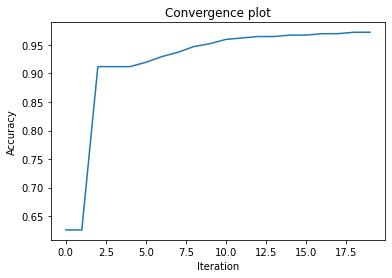

In [12]:
results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')